In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sns

# Cross-validation accuracy calculation for classical ML classification algorithms

In [36]:
def generate_synthetic_dataset(num_samples):
    """ Takes num of samples and return the df with one features and two class """
    np.random.seed(0)
    samples = int(num_samples /2)
    label_0 = np.zeros(samples)
    label_1 = np.ones(samples)

    mu_1 = 12
    sigma_1 = 5
    class_1_data = np.random.normal(mu_1, sigma_1, samples)
    mu_0 = 0
    sigma_0 = 4
    class_0_data = np.random.normal(mu_0, sigma_0, samples)
    data  =  np.concatenate((class_0_data, class_1_data)) 
    labels = np.concatenate((label_0, label_1))

    d = {
        "feature": data,
        "Label": labels
    }
    df = pd.DataFrame(data =d)
    return df



In [37]:
def data_visualization(df):
    class_0_data = df[df['Label'] == 0]['feature']
    class_1_data = df[df['Label'] == 1]['feature']

    plt.figure()
    sns.kdeplot(class_0_data, color='blue', label='Class 0')
    sns.kdeplot(class_1_data, color='red', label='Class 1')

    plt.scatter(class_0_data, np.zeros_like(class_0_data), color='blue', alpha=0.6, label='Class 0 Samples')
    plt.scatter(class_1_data, np.zeros_like(class_1_data), color='red', alpha=0.6, label='Class 1 Samples')

    plt.title('Class Conditional Density Plot of Feature')
    plt.ylim(-0.05, .15)
    plt.xlabel('Feature')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.show()

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
def select_model(model):
    if model == "logistic_regression" :
        return LogisticRegression() 
    elif model == "naive_bayes":
        return GaussianNB()
    elif model == "random_forest":
        return RandomForestClassifier(max_depth=2, random_state=0)
    else:
        raise ValueError("Unknown model type: {}".format(model))

In [39]:
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import accuracy_score
df = generate_synthetic_dataset(1000)

X = df[['feature']]
y = df['Label']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model_names = ["logistic_regression", "naive_bayes", "random_forest"]

for model_name in model_names:
    model = select_model(model_name)
    model.fit(X, y)
    y_pred = model.predict(X)
    # global performance
    global_accuracy = accuracy_score(y, y_pred)
    # Cross validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X, y, cv=kf)
    print(f"Model name: {model_name}, global_accuracy: {global_accuracy}, Scores for each fold: {scores}, Average_score: {np.mean(scores)}")
    


Model name: logistic_regression, global_accuracy: 0.912, Scores for each fold: [0.92  0.915 0.89  0.92  0.91 ], Average_score: 0.9109999999999999
Model name: naive_bayes, global_accuracy: 0.914, Scores for each fold: [0.925 0.925 0.895 0.915 0.905], Average_score: 0.913
Model name: random_forest, global_accuracy: 0.919, Scores for each fold: [0.925 0.935 0.9   0.925 0.9  ], Average_score: 0.9170000000000001


In [48]:
from sklearn.tree import DecisionTreeClassifier, export_text, _tree
from scipy import stats

X = df[['feature']]
y = df['Label']

clf = DecisionTreeClassifier(max_depth=None, min_samples_split = 2, min_samples_leaf =1)
clf.fit(X, y)

training_accuracy = clf.score(X, y)
print(f'Training Accuracy: {training_accuracy * 100:.2f}%')

# Function to extract rules from a trained decision tree
def get_rectangles_from_tree(tree):
    left = tree.tree_.children_left
    right = tree.tree_.children_right
    threshold = tree.tree_.threshold
    # print(left)
    # print(right)
    # print(threshold)

    def recurse(node, bounds):
        if threshold[node] == -2:
            # It's a leaf node
            return bounds
        
        new_bounds_left = []
        new_bounds_right = []
        for left_b, right_b in bounds:
            n_bounds_left = [left_b, threshold[node]]
            n_bounds_right = [threshold[node], right_b]
            new_bounds_left.append(n_bounds_left)
            new_bounds_right.append(n_bounds_right)

        left_rectangles = recurse(left[node], new_bounds_left)
        right_rectangles = recurse(right[node], new_bounds_right)

        return left_rectangles + right_rectangles

    # Initial bounds: [x1_min, x1_max, x2_min, x2_max]
    initial_bounds = [[-np.inf, np.inf]] * tree.tree_.n_features
    print(initial_bounds)
    rectangles = recurse(0, initial_bounds)
    return rectangles

# Example usage
rectangles = get_rectangles_from_tree(clf)

Training Accuracy: 100.00%
[[-inf, inf]]


# Maximum coverage calculation using Decision Tree

In [27]:
from sklearn.tree import DecisionTreeClassifier, export_text, _tree
from scipy import stats

X = df[['feature']]
y = df['Label']

clf = DecisionTreeClassifier(max_depth=None, min_samples_split = 2, min_samples_leaf =1)
clf.fit(X, y)

training_accuracy = clf.score(X, y)
print(f'Training Accuracy: {training_accuracy * 100:.2f}%')

# Function to extract rules from a trained decision tree
def get_rectangles_from_tree(tree):
    left = tree.tree_.children_left
    right = tree.tree_.children_right
    threshold = tree.tree_.threshold

    def recurse(node, bounds):
        if threshold[node] == -2:
            # It's a leaf node
            return bounds
        
        new_bounds_left = []
        new_bounds_right = []
        for left_b, right_b in bounds:
            n_bounds_left = [left_b, threshold[node]]
            n_bounds_right = [threshold[node], right_b]
            new_bounds_left.append(n_bounds_left)
            new_bounds_right.append(n_bounds_right)

        left_rectangles = recurse(left[node], new_bounds_left)
        right_rectangles = recurse(right[node], new_bounds_right)

        return left_rectangles + right_rectangles

    # Initial bounds: [x1_min, x1_max, x2_min, x2_max]
    initial_bounds = [[-np.inf, np.inf]] * tree.tree_.n_features
    rectangles = recurse(0, initial_bounds)
    return rectangles

# Example usage
rectangles = get_rectangles_from_tree(clf)

# Calculate KDE for each class
class_0_data = df[df["Label"] == 0]["feature"]
class_1_data = df[df["Label"] == 1]["feature"]

kde_class_0 = stats.gaussian_kde(class_0_data)
kde_class_1 = stats.gaussian_kde(class_1_data)

# Calculate probabilities for the segments
segment_probabilities = []
for start, end in rectangles:
    segment = df[(df['feature'] >= start) & (df['feature'] < end)]
    if not segment.empty:
        actual_value = segment["Label"].iloc[0]   # taking the actual value of the first sample of that segment
        if actual_value == 0.0:
            segment_probabilities.append(kde_class_1.integrate_box_1d(start, end))
        else:
            segment_probabilities.append(kde_class_0.integrate_box_1d(start, end))

# Compute total error probability
total_error_probability_all_segments = np.sum(segment_probabilities)

print(f"Total error probability across all segments: {total_error_probability_all_segments:.4f}")
print(f"Accuracy: {1 - total_error_probability_all_segments:.4f}")

Training Accuracy: 100.00%
Total error probability across all segments: 0.2690
Accuracy: 0.7310


In [26]:
rectangles

[[-inf, -1.8715476393699646],
 [-1.8715476393699646, -1.8601572513580322],
 [-1.8601572513580322, -1.69851952791214],
 [-1.69851952791214, -1.6699565052986145],
 [-1.6699565052986145, -1.2992695569992065],
 [-1.2992695569992065, -1.2741339206695557],
 [-1.2741339206695557, -0.7688279449939728],
 [-0.7688279449939728, -0.7469640970230103],
 [-0.7469640970230103, 0.5087456405162811],
 [0.5087456405162811, 0.5753490626811981],
 [0.5753490626811981, 0.7186751663684845],
 [0.7186751663684845, 0.727767825126648],
 [0.727767825126648, 0.8805112242698669],
 [0.8805112242698669, 0.8891792297363281],
 [0.8891792297363281, 0.9886923432350159],
 [0.9886923432350159, 1.0013900399208069],
 [1.0013900399208069, 1.5219634175300598],
 [1.5219634175300598, 1.528957188129425],
 [1.528957188129425, 1.6378684043884277],
 [1.6378684043884277, 1.6507790684700012],
 [1.6507790684700012, 1.8308526277542114],
 [1.8308526277542114, 1.8556216955184937],
 [1.8556216955184937, 1.9127801656723022],
 [1.9127801656723

In [62]:
# data_visualization(df)

# Theoretical error calculation from cross over area calculation

model.

In [49]:
# Function for the calculate the common area between the two pdf
from scipy import stats
from scipy.integrate import cumulative_trapezoid

def calculate_pdf(df):
    """Calculate pdf using kernel density estimate"""
    class_0_data = df[df["Label"] == 0]["feature"]
    class_1_data = df[df['Label'] == 1]['feature']
    kde0 = stats.gaussian_kde(class_0_data)
    kde1 = stats.gaussian_kde(class_1_data)

    return kde0, kde1

def calculate_cdf(kde, th):
    return kde.integrate_box_1d(-np.inf, th)

def calculate_crossover_area(cdf1, cdf2):
    common_area = 1- cdf1  + cdf2
    return common_area
    
kde0, kde1 = calculate_pdf(df)
max = df["feature"].max()

x = np.linspace(-15, 30, 50000)
y1 = kde0.pdf(x)
y2 = kde1.pdf(x)
intersection_point = np.argmin(np.abs(y1-y2))

cdf1 = calculate_cdf(kde0, x[intersection_point])
cdf2 = calculate_cdf(kde1, x[intersection_point])
print(x[intersection_point])

area = calculate_crossover_area(cdf1, cdf2)
print(f"The cross over area between the two pdf is: {area: .4f}")


5.477209544190885
The cross over area between the two pdf is:  0.1881


# Maximum coverage calculation using segmentaion method over the feature space

In [51]:
# error computation within particular segment 
# Divide the sample space and generate the pdf and cdf
# then calculate the error form them

display(df.shape)
# segment the dataset
df = df.sort_values("feature")
#display(df.head())
diff = df["Label"].diff()
diff =diff.bfill()

change_points = df["feature"][(np.abs(diff)>0).shift(-1, fill_value=False)].values + (df["feature"][np.abs(diff)>0].values - df["feature"][(np.abs(diff)>0).shift(-1, fill_value=False)].values) /2
segments = [(df['feature'].min(), change_points[0])] + \
           [(change_points[i], change_points[i + 1]) for i in range(len(change_points) - 1)] + \
           [(change_points[-1], df['feature'].max())]
segments

class_0_data = df[df["Label"] == 0]["feature"]
class_1_data = df[df["Label"] == 1]["feature"]

kde_class_0 = stats.gaussian_kde(class_0_data)
kde_class_1 = stats.gaussian_kde(class_1_data)
x = np.linspace(-15, 30, 50000)
y1 = kde_class_0.pdf(x)
y2 = kde_class_1.pdf(x)

segment_probabilities = []
for start, end in segments:
    segment = df[(df['feature'] >= start) & (df['feature'] < end)]
    print(start, end)
    actual_value = segment["Label"].iloc[0]   # taking the actual value of the first sample of that segment
    #print(actual_value)
    probabilities = []
    
    if actual_value == 0.0:
        segment_probabilities.append(kde_class_1.integrate_box_1d(start, end))
    else:
        segment_probabilities.append(kde_class_0.integrate_box_1d(start, end))
        
    
    
print(segment_probabilities)
total_error_probability_all_segments = np.sum(segment_probabilities)



print(f"Total error probability across all segments: {total_error_probability_all_segments:.4f}")


print(f"Accuracy: {1- total_error_probability_all_segments}")


(1000, 2)

-12.184572219199707 -1.8715476564683753
-1.8715476564683753 -1.8601572739376089
-1.8601572739376089 -1.6985195228396224
-1.6985195228396224 -1.6699565052896324
-1.6699565052896324 -1.2992695326322004
-1.2992695326322004 -1.2741339202977304
-1.2741339202977304 -0.7688279426848761
-0.7688279426848761 -0.7469641071650821
-0.7469641071650821 0.5087456462438632
0.5087456462438632 0.575349062723835
0.575349062723835 0.7186751579608863
0.7186751579608863 0.727767825009729
0.727767825009729 0.8805112310250242
0.8805112310250242 0.889179246064755
0.889179246064755 0.9886923636182939
0.9886923636182939 1.0013900404023506
1.0013900404023506 1.521963389055812
1.521963389055812 1.5289571820091745
1.5289571820091745 1.6378684248185806
1.6378684248185806 1.6507790783585174
1.6507790783585174 1.8308526558176321
1.8308526558176321 1.8556216826143257
1.8556216826143257 1.9127801683450443
1.9127801683450443 1.9212136832782702
1.9212136832782702 2.09061632599161
2.09061632599161 2.1020172463495017
2.10201

# Maximum coverage for Multi dimensional features

Training Accuracy: 100.00%
0
1
0
[([[-8, 8], [-8, 0.742154449224472]], 0), ([[-8, 0.9186029061675072], [0.742154449224472, 8]], 1), ([[0.9186029061675072, 8], [0.742154449224472, 8]], 0)]
Total error probability across all segments: 0.1368
Accuracy: 0.8632


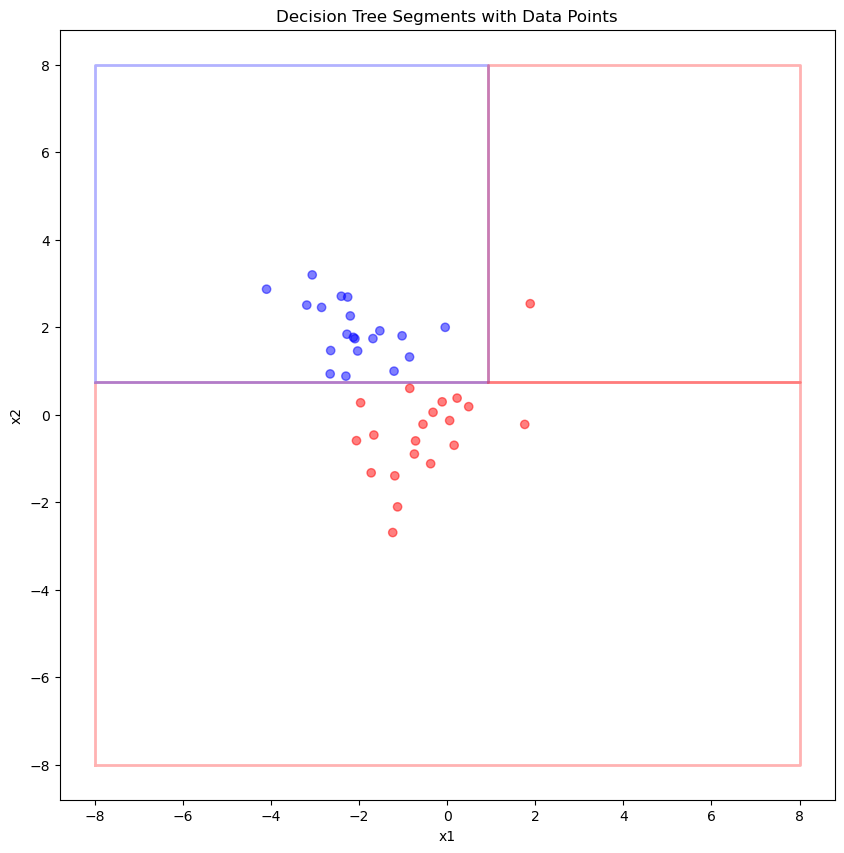

In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, _tree
from matplotlib.patches import Rectangle

def generate_two_dimensional_data(num_samples_per_class):
    np.random.seed(0)  

    # Class 0
    mean_0 = [0, 0]
    cov_0 = [[1, 0.5], [0.5, 1]] 
    class_0_data = np.random.multivariate_normal(mean_0, cov_0, num_samples_per_class)
    label_0 = np.zeros(num_samples_per_class)

    # Class 1
    mean_1 = [-2.5, 2.5]
    cov_1 = [[1, -0.5], [-0.5, 1]] 
    class_1_data = np.random.multivariate_normal(mean_1, cov_1, num_samples_per_class)
    label_1 = np.ones(num_samples_per_class)

    # Concatenate data and labels
    data = np.vstack((class_0_data, class_1_data))
    labels = np.concatenate((label_0, label_1))

    # Create DataFrame
    df = pd.DataFrame(data, columns=['x1', 'x2'])
    df['Label'] = labels

    return df

# Generate dataset
df = generate_two_dimensional_data(20)

from sklearn.tree import DecisionTreeClassifier, export_text, _tree
X = df[['x1', 'x2']]
y = df['Label']

clf = DecisionTreeClassifier(max_depth=None)
clf.fit(X, y)

training_accuracy = clf.score(X, y)
print(f'Training Accuracy: {training_accuracy * 100:.2f}%')

# Function to extract rectangles and labels from a trained decision tree
def get_rectangles_from_tree(tree):
    left = tree.tree_.children_left
    right = tree.tree_.children_right
    threshold = tree.tree_.threshold
    feature = tree.tree_.feature  # feature used for splitting node i
    value = tree.tree_.value  # the predicted class distribution at each node
    # print("values")
    # print(value)
    
    def recurse(node, bounds):
        if feature[node] == -2:
            # It's a leaf node
            leaf_label = np.argmax(value[node][0])
            print(leaf_label)
            return [(bounds, leaf_label)]
        
        new_bounds_left = [list(b) for b in bounds]
        new_bounds_right = [list(b) for b in bounds]
        
        feature_index = feature[node]
        threshold_value = threshold[node]
        
        new_bounds_left[feature_index][1] = threshold_value
        new_bounds_right[feature_index][0] = threshold_value
        
        left_rectangles = recurse(left[node], new_bounds_left)
        right_rectangles = recurse(right[node], new_bounds_right)
        
        return left_rectangles + right_rectangles

    # Initial bounds: [[x1_min, x1_max], [x2_min, x2_max]]
    initial_bounds = [[-8, 8]] * tree.tree_.n_features
    rectangles = recurse(0, initial_bounds)
    return rectangles

# Extract rectangles and labels from the decision tree
rectangles = get_rectangles_from_tree(clf)
print(rectangles)

class_0_data = df[df["Label"] == 0][['x1', 'x2']]
class_1_data = df[df["Label"] == 1][['x1', 'x2']]

kde_class_0 = stats.gaussian_kde(class_0_data.T)
kde_class_1 = stats.gaussian_kde(class_1_data.T)

# Calculate probabilities for the segments
segment_probabilities = []
for rect, label in rectangles:
    (x1_start, x1_end), (x2_start, x2_end) = rect
    segment = df[(df['x1'] >= x1_start) & (df['x1'] < x1_end) & (df['x2'] >= x2_start) & (df['x2'] < x2_end)]
    if not segment.empty:
        actual_value = segment["Label"].iloc[0]
        if actual_value == 0.0:
            segment_probabilities.append(kde_class_1.integrate_box([x1_start, x2_start], [x1_end, x2_end]))
        else:
            segment_probabilities.append(kde_class_0.integrate_box([x1_start, x2_start], [x1_end, x2_end]))

# Compute total error probability
total_error_probability_all_segments = np.sum(segment_probabilities)

print(f"Total error probability across all segments: {total_error_probability_all_segments:.4f}")
print(f"Accuracy: {1 - total_error_probability_all_segments:.4f}")

# Plotting the data points and rectangles
plt.figure(figsize=(10, 10))
colors = ['red' if label == 0 else 'blue' for label in df['Label']]
plt.scatter(df['x1'], df['x2'], c=colors, alpha=0.5, label='Data Points')

# Plot the rectangles
for rect, label in rectangles:
    (x1_start, x1_end), (x2_start, x2_end) = rect
    color = 'red' if label == 0 else 'blue'
    plt.plot([x1_start, x1_start, x1_end, x1_end, x1_start], 
             [x2_start, x2_end, x2_end, x2_start, x2_start], 
             color=color, alpha=0.3, lw=2)

plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Decision Tree Segments with Data Points')

plt.show()


In [22]:
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import accuracy_score

# X = df[['feature']]
# y = df['Label']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model_names = ["logistic_regression", "naive_bayes", "random_forest"]

for model_name in model_names:
    model = select_model(model_name)
    model.fit(X, y)
    y_pred = model.predict(X)
    # global performance
    global_accuracy = accuracy_score(y, y_pred)
    # Cross validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X, y, cv=kf)
    print(f"Model name: {model_name}, global_accuracy: {global_accuracy}, Scores for each fold: {scores}, Average_score: {np.mean(scores)}")

Model name: logistic_regression, global_accuracy: 0.975, Scores for each fold: [0.97  0.975 0.97  0.99  0.96 ], Average_score: 0.9730000000000001
Model name: naive_bayes, global_accuracy: 0.963, Scores for each fold: [0.955 0.945 0.965 0.97  0.98 ], Average_score: 0.9629999999999999
Model name: random_forest, global_accuracy: 0.969, Scores for each fold: [0.965 0.95  0.96  0.975 0.975], Average_score: 0.9650000000000001


In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

def generate_two_dimensional_data(num_samples_per_class):
    np.random.seed(0)  

    # Class 0
    mean_0 = [0, 0]
    cov_0 = [[1, 0.5], [0.5, 1]] 
    class_0_data = np.random.multivariate_normal(mean_0, cov_0, num_samples_per_class)
    label_0 = np.zeros(num_samples_per_class)

    # Class 1
    mean_1 = [2.5, 2.5]
    cov_1 = [[1, -0.5], [-0.5, 1]] 
    class_1_data = np.random.multivariate_normal(mean_1, cov_1, num_samples_per_class)
    label_1 = np.ones(num_samples_per_class)

    # Concatenate data and labels
    data = np.vstack((class_0_data, class_1_data))
    labels = np.concatenate((label_0, label_1))

    # Create DataFrame
    df = pd.DataFrame(data, columns=['x1', 'x2'])
    df['Label'] = labels

    return df

# Generate dataset
df = generate_two_dimensional_data(500)

from sklearn.tree import DecisionTreeClassifier, export_text, _tree
X = df[['x1', 'x2']]
y = df['Label']

clf = DecisionTreeClassifier(max_depth=None)
clf.fit(X, y)

training_accuracy = clf.score(X, y)
print(f'Training Accuracy: {training_accuracy * 100:.2f}%')

# Function to extract rules from a trained decision tree
def get_rectangles_from_tree(tree):
    left = tree.tree_.children_left
    right = tree.tree_.children_right
    threshold = tree.tree_.threshold
    feature = tree.tree_.feature  # feature used for splitting node i
    print(feature)
    def recurse(node, bounds):
        if feature[node] == -2:
            # It's a leaf node
            return [bounds]
        
        new_bounds_left = bounds.copy()
        new_bounds_right = bounds.copy()
        left_b, right_b = bounds[feature[node]]
        # print(feature[node])
        n_bounds_left = [left_b, threshold[node]]
        n_bounds_right = [threshold[node], right_b]
        new_bounds_left[feature[node]] = n_bounds_left
        new_bounds_right[feature[node]] = n_bounds_right

        left_rectangles = recurse(left[node], new_bounds_left)
        right_rectangles = recurse(right[node], new_bounds_right)

        return left_rectangles + right_rectangles

    # Initial bounds: [x1_min, x1_max, x2_min, x2_max]
    initial_bounds = [[-np.inf, np.inf]] * tree.tree_.n_features
    # print(initial_bounds)
    rectangles = recurse(0, initial_bounds)
    return rectangles

# Example usage
rectangles = get_rectangles_from_tree(clf)
rectangles


Training Accuracy: 100.00%
[ 1  0 -2 -2  0  1 -2 -2  1  0  1 -2  1  0  1 -2 -2 -2 -2  0  1  1  0 -2
 -2 -2  0 -2  0 -2 -2  0  0  0  0 -2 -2 -2 -2 -2  0  1  0 -2  0 -2  0 -2
  0 -2  0  0  1 -2 -2 -2 -2  1  1  0  1  1  1 -2  1 -2 -2 -2 -2  1 -2 -2
 -2 -2 -2]


[[[-inf, 2.2463499307632446], [-inf, 1.0163397192955017]],
 [[2.2463499307632446, inf], [-inf, 1.0163397192955017]],
 [[-inf, 0.6475275754928589], [1.0163397192955017, 2.499490976333618]],
 [[-inf, 0.6475275754928589], [2.499490976333618, inf]],
 [[0.6475275754928589, 1.6884258389472961],
  [1.0163397192955017, 1.5704632997512817]],
 [[0.6475275754928589, 1.329886555671692],
  [1.5704632997512817, 1.6689112782478333]],
 [[0.6475275754928589, 1.329886555671692],
  [1.6689112782478333, 1.6748170852661133]],
 [[1.329886555671692, 1.6884258389472961],
  [1.5704632997512817, 1.6748170852661133]],
 [[0.6475275754928589, 1.6884258389472961],
  [1.6748170852661133, 1.7796217799186707]],
 [[1.6884258389472961, 2.0789849758148193],
  [1.0163397192955017, 1.3037762641906738]],
 [[2.0789849758148193, 2.152440905570984],
  [1.0163397192955017, 1.3037762641906738]],
 [[1.6884258389472961, 2.152440905570984],
  [1.3037762641906738, 1.3686426877975464]],
 [[1.6884258389472961, 2.0128698348999023],
  [

Training Accuracy: 100.00%
Node 0 splits on feature 0 at 0.8352600932121277
Left bounds: [[-10, 0.8352600932121277], [-10, 10]]
Right bounds: [[0.8352600932121277, 10], [-10, 10]]
Node 1 splits on feature 1 at 2.955018997192383
Left bounds: [[-10, 0.8352600932121277], [-10, 2.955018997192383]]
Right bounds: [[-10, 0.8352600932121277], [2.955018997192383, 10]]
Leaf node reached with bounds: [[-10, 0.8352600932121277], [-10, 2.955018997192383]]
Leaf node reached with bounds: [[-10, 0.8352600932121277], [2.955018997192383, 10]]
Node 4 splits on feature 1 at 0.6478080749511719
Left bounds: [[0.8352600932121277, 10], [-10, 0.6478080749511719]]
Right bounds: [[0.8352600932121277, 10], [0.6478080749511719, 10]]
Leaf node reached with bounds: [[0.8352600932121277, 10], [-10, 0.6478080749511719]]
Node 6 splits on feature 0 at 1.8903265595436096
Left bounds: [[0.8352600932121277, 1.8903265595436096], [0.6478080749511719, 10]]
Right bounds: [[1.8903265595436096, 10], [0.6478080749511719, 10]]
Nod

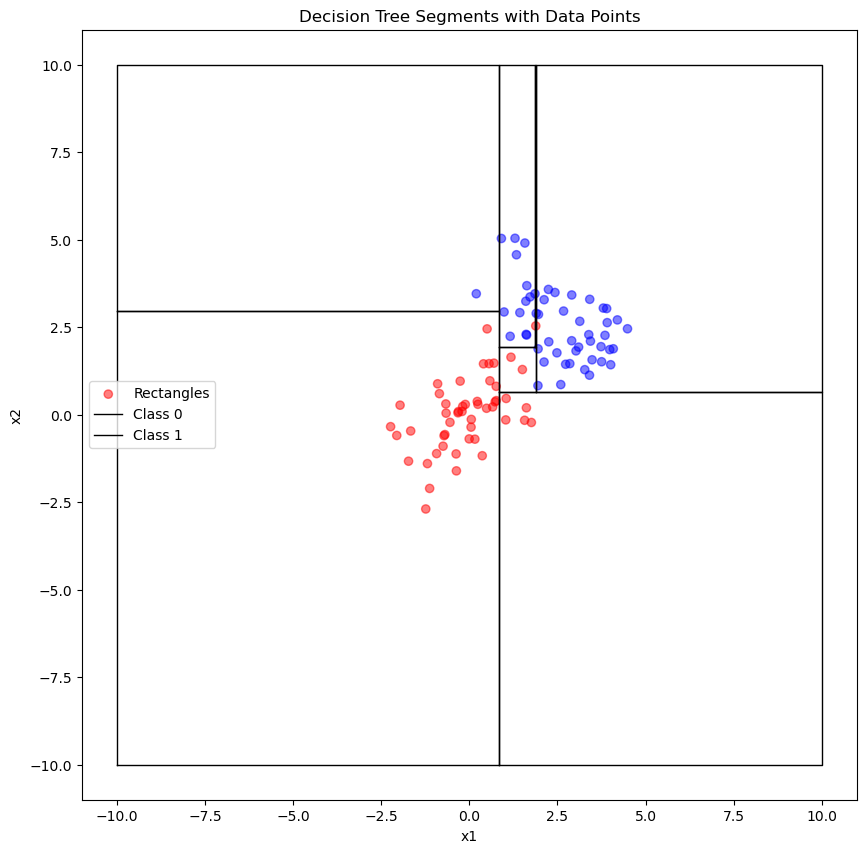

7


In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, _tree
from scipy import stats

def generate_two_dimensional_data(num_samples_per_class):
    np.random.seed(0)

    # Class 0
    mean_0 = [0, 0]
    cov_0 = [[1, 0.5], [0.5, 1]]
    class_0_data = np.random.multivariate_normal(mean_0, cov_0, num_samples_per_class)
    label_0 = np.zeros(num_samples_per_class)

    # Class 1
    mean_1 = [2.5, 2.5]
    cov_1 = [[1, -0.5], [-0.5, 1]]
    class_1_data = np.random.multivariate_normal(mean_1, cov_1, num_samples_per_class)
    label_1 = np.ones(num_samples_per_class)

    # Concatenate data and labels
    data = np.vstack((class_0_data, class_1_data))
    labels = np.concatenate((label_0, label_1))

    # Create DataFrame
    df = pd.DataFrame(data, columns=['x1', 'x2'])
    df['Label'] = labels

    return df

# Generate dataset
df = generate_two_dimensional_data(50)

X = df[['x1', 'x2']]
y = df['Label']

clf = DecisionTreeClassifier(max_depth=None, min_samples_split=2, min_samples_leaf=1)
clf.fit(X, y)

training_accuracy = clf.score(X, y)
print(f'Training Accuracy: {training_accuracy * 100:.2f}%')

# Function to extract rules from a trained decision tree
def get_rectangles_from_tree(tree):
    left = tree.tree_.children_left
    right = tree.tree_.children_right
    threshold = tree.tree_.threshold
    feature = tree.tree_.feature

    def recurse(node, bounds):
        if feature[node] == _tree.TREE_UNDEFINED:
            # It's a leaf node
            print(f"Leaf node reached with bounds: {bounds}")
            return [bounds]
        
        new_bounds_left = [list(b) for b in bounds]
        new_bounds_right = [list(b) for b in bounds]

        feature_index = feature[node]
        threshold_value = threshold[node]
        
        new_bounds_left[feature_index][1] = threshold_value
        new_bounds_right[feature_index][0] = threshold_value

        print(f"Node {node} splits on feature {feature_index} at {threshold_value}")
        print(f"Left bounds: {new_bounds_left}")
        print(f"Right bounds: {new_bounds_right}")
        
        left_rectangles = recurse(left[node], new_bounds_left)
        right_rectangles = recurse(right[node], new_bounds_right)

        return left_rectangles + right_rectangles

    # Initial bounds for each feature
    initial_bounds = [[-10, 10] for _ in range(tree.tree_.n_features)]
    rectangles = recurse(0, initial_bounds)
    return rectangles

# Extract rectangles from the decision tree
rectangles = get_rectangles_from_tree(clf)

# Calculate KDE for each class
class_0_data = df[df["Label"] == 0][['x1', 'x2']]
class_1_data = df[df["Label"] == 1][['x1', 'x2']]

kde_class_0 = stats.gaussian_kde(class_0_data.T)
kde_class_1 = stats.gaussian_kde(class_1_data.T)

# Calculate probabilities for the segments
segment_probabilities = []
for rect in rectangles:
    (x1_start, x1_end), (x2_start, x2_end) = rect
    segment = df[(df['x1'] >= x1_start) & (df['x1'] < x1_end) & (df['x2'] >= x2_start) & (df['x2'] < x2_end)]
    if not segment.empty:
        actual_value = segment["Label"].iloc[0]
        if actual_value == 0.0:
            segment_probabilities.append(kde_class_1.integrate_box([x1_start, x2_start], [x1_end, x2_end]))
        else:
            segment_probabilities.append(kde_class_0.integrate_box([x1_start, x2_start], [x1_end, x2_end]))

# Compute total error probability
total_error_probability_all_segments = np.sum(segment_probabilities)

print(f"Total error probability across all segments: {total_error_probability_all_segments:.4f}")
print(f"Accuracy: {1 - total_error_probability_all_segments:.4f}")

# Plotting the rectangles and data points
plt.figure(figsize=(10, 10))
colors = ['red' if label == 0 else 'blue' for label in df['Label']]
plt.scatter(df['x1'], df['x2'], c=colors, alpha=0.5, label='Data Points')

for rect in rectangles:
    (x1_start, x1_end), (x2_start, x2_end) = rect
    plt.plot([x1_start, x1_start, x1_end, x1_end, x1_start], [x2_start, x2_end, x2_end, x2_start, x2_start], 'k-', lw=1)

plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Decision Tree Segments with Data Points')
plt.legend(['Rectangles', 'Class 0', 'Class 1'])
plt.show()

print(len(rectangles))

In [26]:
len(rectangles)

38

In [93]:
clf.tree_.feature

array([ 1,  0, -2, -2,  0,  1, -2, -2,  1,  0,  1, -2,  1,  0,  1, -2, -2,
       -2, -2,  0,  1,  1,  0, -2, -2, -2,  0, -2,  0, -2, -2,  0,  0,  0,
        0, -2, -2, -2, -2, -2,  0,  1,  0, -2,  0, -2,  0, -2,  0, -2,  0,
        0,  1, -2, -2, -2, -2,  1,  1,  0,  1,  1,  1, -2,  1, -2, -2, -2,
       -2,  1, -2, -2, -2, -2, -2], dtype=int64)

# Discrete classification case

In [37]:
import pandas as pd

# Data
data = {
    "x1": [0, 0, 1, 1, 0, 0, 1],
    "x2": [0, 1, 0, 1, 0, 0, 0],
    "L": [0, 1, 1, 0, 1, 0, 0]
}
df1 = pd.DataFrame(data)


def majority_vote(df, feature_columns, class_column):
    # combinaion generators
    df["feature_combination"] = df[feature_columns].astype(str).agg('_'.join, axis=1)
    
    # total no of combinations
    combination_counts = df.groupby(['feature_combination', class_column]).size().reset_index(name='count')
    
    # no of combination
    total_combination_counts = df['feature_combination'].value_counts().reset_index(name='total_count').rename(columns={'index': 'feature_combination'})
    
    combination_probs = pd.merge(combination_counts, total_combination_counts, on='feature_combination')
    combination_probs['probability'] = combination_probs['count'] / combination_probs['total_count']
    
    
    combination_probs_pivot = combination_probs.pivot(index='feature_combination', columns=class_column, values='probability').fillna(0)
    combination_probs_pivot.columns = [f'P(class={int(col)})' for col in combination_probs_pivot.columns]
    
    df = pd.merge(df, combination_probs, on=['feature_combination', class_column], how='left')
    
    return df, combination_probs_pivot



df, combination_pivot = majority_vote(df1, feature_columns=["x1", "x2"], class_column="L")

print(df)
print(combination_pivot)


   x1  x2  L feature_combination  count  total_count  probability
0   0   0  0                 0_0      2            3     0.666667
1   0   1  1                 0_1      1            1     1.000000
2   1   0  1                 1_0      1            2     0.500000
3   1   1  0                 1_1      1            1     1.000000
4   0   0  1                 0_0      1            3     0.333333
5   0   0  0                 0_0      2            3     0.666667
6   1   0  0                 1_0      1            2     0.500000
                     P(class=0)  P(class=1)
feature_combination                        
0_0                    0.666667    0.333333
0_1                    0.000000    1.000000
1_0                    0.500000    0.500000
1_1                    1.000000    0.000000


In [31]:
from sklearn.datasets import load_iris
data = load_iris()
x = data.data
y = data.target
dtc = DecisionTreeClassifier().fit(x, y)
rectangles = decision_areas(dtc, [0, 7, 0, 5], x=2, y=3)
plt.scatter(x[:, 2], x[:, 3], c=y)
plot_areas(rectangles)

NameError: name 'decision_areas' is not defined

Training Accuracy: 100.00%
[[-10.          10.         -10.           0.60912332   0.        ]
 [-10.          10.           0.60912332  10.           1.        ]]


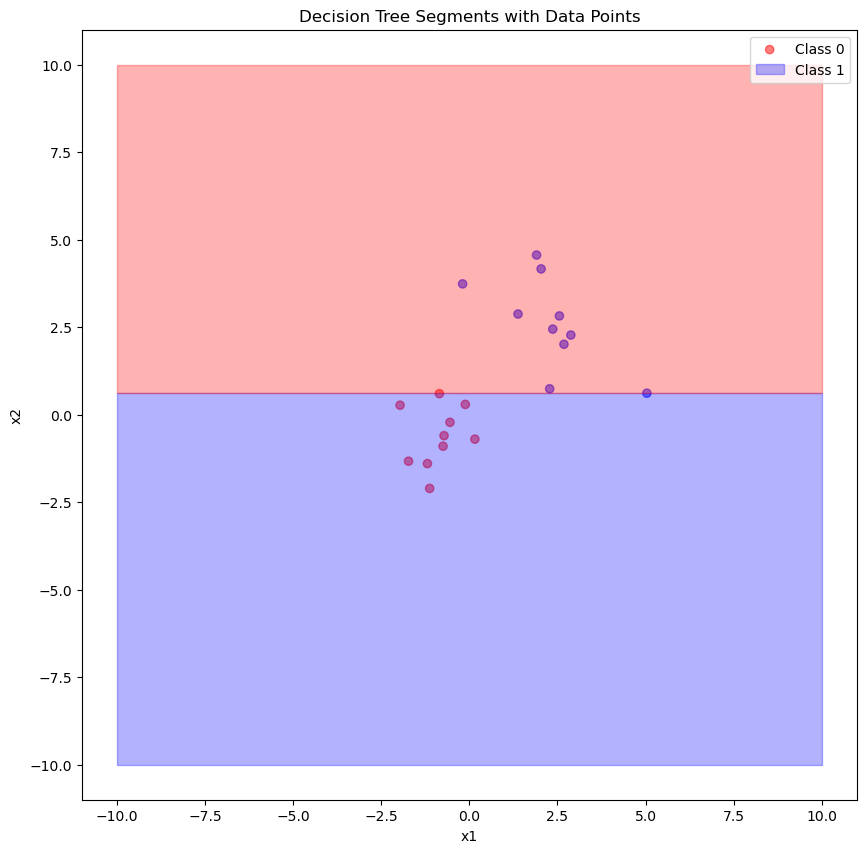

In [57]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from collections import deque
from sklearn.tree import _tree as ctree

# Data generation function
def generate_two_dimensional_data(num_samples_per_class):
    np.random.seed(0)

    # Class 0
    mean_0 = [0, 0]
    cov_0 = [[1, 0.5], [0.5, 1]]
    class_0_data = np.random.multivariate_normal(mean_0, cov_0, num_samples_per_class)
    label_0 = np.zeros(num_samples_per_class)

    # Class 1
    mean_1 = [2.5, 2.5]
    cov_1 = [[1, -0.5], [-0.5, 1]]
    class_1_data = np.random.multivariate_normal(mean_1, cov_1, num_samples_per_class)
    label_1 = np.ones(num_samples_per_class)

    # Concatenate data and labels
    data = np.vstack((class_0_data, class_1_data))
    labels = np.concatenate((label_0, label_1))

    # Create DataFrame
    df = pd.DataFrame(data, columns=['x1', 'x2'])
    df['Label'] = labels

    return df

# Generate dataset
df = generate_two_dimensional_data(20)

X = df[['x1', 'x2']]
y = df['Label']

clf = DecisionTreeClassifier(max_depth=None, min_samples_split=2, min_samples_leaf=1)
clf.fit(X, y)

training_accuracy = clf.score(X, y)
print(f'Training Accuracy: {training_accuracy * 100:.2f}%')

# AABB and tree bounds classes/functions
class AABB:
    """Axis-aligned bounding box"""
    def __init__(self, n_features):
        self.limits = np.array([[-np.inf, np.inf]] * n_features)

    def split(self, f, v):
        left = AABB(self.limits.shape[0])
        right = AABB(self.limits.shape[0])
        left.limits = self.limits.copy()
        right.limits = self.limits.copy()

        left.limits[f, 1] = v
        right.limits[f, 0] = v

        return left, right

def tree_bounds(tree, n_features=None):
    """Compute final decision rule for each node in tree"""
    if n_features is None:
        n_features = np.max(tree.feature) + 1
    aabbs = [AABB(n_features) for _ in range(tree.node_count)]
    queue = deque([0])
    while queue:
        i = queue.pop()
        l = tree.children_left[i]
        r = tree.children_right[i]
        if l != ctree.TREE_LEAF:
            aabbs[l], aabbs[r] = aabbs[i].split(tree.feature[i], tree.threshold[i]) # 
            queue.extend([l, r])
    return aabbs

def decision_areas(tree_classifier, maxrange, x=0, y=1, n_features=None):
    """ Extract decision areas.

    tree_classifier: Instance of a sklearn.tree.DecisionTreeClassifier
    maxrange: values to insert for [left, right, top, bottom] if the interval is open (+/-inf) 
    x: index of the feature that goes on the x axis
    y: index of the feature that goes on the y axis
    n_features: override autodetection of number of features
    """
    tree = tree_classifier.tree_
    aabbs = tree_bounds(tree, n_features)
    

    rectangles = []
    for i in range(len(aabbs)):
        if tree.children_left[i] != ctree.TREE_LEAF:
            continue
        l = aabbs[i].limits
        r = [l[x, 0], l[x, 1], l[y, 0], l[y, 1], np.argmax(tree.value[i])]
        rectangles.append(r)
    rectangles = np.array(rectangles)
    
    rectangles[:, [0, 2]] = np.maximum(rectangles[:, [0, 2]], maxrange[0::2])
    
    rectangles[:, [1, 3]] = np.minimum(rectangles[:, [1, 3]], maxrange[1::2])
    
    return rectangles
    

def plot_areas(rectangles):
    for rect in rectangles:
        color = ['b', 'r'][int(rect[4])]
        rp = Rectangle([rect[0], rect[2]], 
                       rect[1] - rect[0], 
                       rect[3] - rect[2], color=color, alpha=0.3)
        plt.gca().add_patch(rp)

# Extract decision areas
maxrange = [-10, 10, -10, 10]  # adjust based on your data range
rectangles = decision_areas(clf, maxrange)
print(rectangles)


class_0_data = df[df["Label"] == 0][['x1', 'x2']]
class_1_data = df[df["Label"] == 1][['x1', 'x2']]

kde_class_0 = stats.gaussian_kde(class_0_data.T)
kde_class_1 = stats.gaussian_kde(class_1_data.T)

# Calculate probabilities for the segments
segment_probabilities = []
for rect, label in rectangles:
    (x1_start, x1_end), (x2_start, x2_end) = rect
    segment = df[(df['x1'] >= x1_start) & (df['x1'] < x1_end) & (df['x2'] >= x2_start) & (df['x2'] < x2_end)]
    if not segment.empty:
        actual_value = segment["Label"].iloc[0]
        if actual_value == 0.0:
            segment_probabilities.append(kde_class_1.integrate_box([x1_start, x2_start], [x1_end, x2_end]))
        else:
            segment_probabilities.append(kde_class_0.integrate_box([x1_start, x2_start], [x1_end, x2_end]))

# Compute total error probability
total_error_probability_all_segments = np.sum(segment_probabilities)

print(f"Total error probability across all segments: {total_error_probability_all_segments:.4f}")
print(f"Accuracy: {1 - total_error_probability_all_segments:.4f}")

# Plot the data points and decision areas
plt.figure(figsize=(10, 10))
colors = ['red' if label == 0 else 'blue' for label in df['Label']]
plt.scatter(df['x1'], df['x2'], c=colors, alpha=0.5, label='Data Points')

# Plot the decision areas
plot_areas(rectangles)

plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Decision Tree Segments with Data Points')
plt.legend(['Class 0', 'Class 1'])
plt.show()
